In [1]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

from qiskit.tools.monitor import *
%matplotlib inline

from scipy.linalg import expm
import matplotlib.pyplot as plt
from ibm_quantum_widgets import CircuitComposer


# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
#### Exact time evolution 
# Pauli matrices

S_x = np.matrix([[0.0,1.0],[1.0,0.0]])
S_y = np.matrix([[0.0,-1.0j],[1.0j,0.0]])
S_z = np.matrix([[1.0,0.0],[0.0,-1.0]])
Id = np.matrix([[1.0,0.0],[0.0,1.0]])

# Single qubit states 0 and 1 in computational basis
vect_0 = np.matrix([[1.0],[0.0]])
vect_1 = np.matrix([[0.0],[1.0]])



In [3]:
# The Schwinger model parameters
mu = 0.1
x = 0.6

In [4]:
# Unitarytime evolution operator under H

def U_exact(t,x,mu):
    H = (x/np.sqrt(2))*np.kron(S_x,S_x) + (x/np.sqrt(2))*np.kron(S_y,S_y) - mu*np.kron(S_z,S_z) +\
    x*(1.0 + (1.0/np.sqrt(2)))*np.kron(Id,S_x) - 0.5*np.kron(Id,S_z) - (1.0 + mu)*np.kron(S_z,Id) +\
    x*(1.0 - (1.0/np.sqrt(2)))*np.kron(S_z, S_x)
    return expm(-1.0j*t*H)


Probability 01 =  [0.0, 0.014279532227667731, 0.05569589690867274, 0.1201536813864746, 0.20137353020348137, 0.2916295751523156, 0.38263162083894314, 0.4664317568927078, 0.5362372307766643, 0.587031522308546, 0.6159394179540106, 0.6223130899996523, 0.607557410658409, 0.5747471148374631, 0.528110837539648, 0.4724649524394642, 0.4126738840283906, 0.3531961238930574, 0.2977513311140845, 0.2491191063043279]


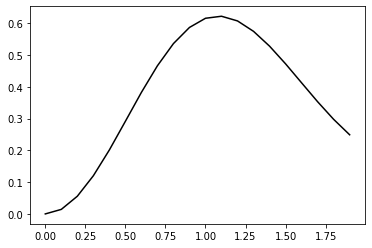

In [5]:
# time step
dt = 0.1
# number of time step
NSteps = 20
nSteps = [n for n in range(NSteps)]

# initial state
v00 = np.kron(vect_0,vect_0)
# electron-positron pair state
v01 = np.kron(vect_0,vect_1)

P01_exact = []

for j in range(NSteps):
    t = nSteps[j]*dt
    res = np.transpose(v01)*U_exact(t,x,mu)*v00
    P01_exact.append(np.abs(res[0,0])**2)
    
print('Probability 01 = ', P01_exact)
Time = dt*np.arange(0,NSteps,1)
plt.plot(Time, P01_exact, 'black')

In [6]:
#### Trotterized time dynamics with Qiskit

q = QuantumRegister(2,'q')
c = ClassicalRegister(2, 'c')
circ = QuantumCircuit(q,c)


def U_trot(dt,q):
    
    circ.rxx(-2.0*(0.6/np.sqrt(2))*dt, 0, 1) 
    circ.sdg(q)
    circ.rxx(-2.0*(0.6/np.sqrt(2)*dt), 0, 1)
    circ.s(q)
    circ.h(q)
    circ.rxx(2.0*0.1*dt, 0, 1) 
    circ.h(q)
    circ.rx(-2.0*0.6*(1.0 + (1.0/np.sqrt(2)))*dt, 1) #0 ou 1 le qubit 
    circ.rz(1.0*dt, 1) 
    circ.rz(2.0*(1.0 + 0.1)*dt, 0)
    circ.h(0)
    circ.rxx(-2.0*0.6*(1.0 - (1.0/np.sqrt(2)))*dt, 0, 1) 
    circ.h(0)

    return circ

def U_approx(circ, dt, nSteps, q):
    if nSteps>0:
        for ind in range(nSteps): 
            circ = U_trot(dt, q)  
    else: 
        circ = U_trot(0,q)
    return circ
    


Probability 01 =  [8.024582750190568e-32, 0.014313156771279416, 0.056026902699410464, 0.12129368419059881, 0.20398326507098963, 0.29639051486161255, 0.39011053854319555, 0.47696159768404267, 0.5498342224999619, 0.6033615686009527, 0.6343378778320995, 0.6418528090240887, 0.6271520713363146, 0.5932720056577452, 0.5445217666459916, 0.4858982665517088, 0.42251568446160365, 0.3591155418376728, 0.299699617579819, 0.24730186704778465]


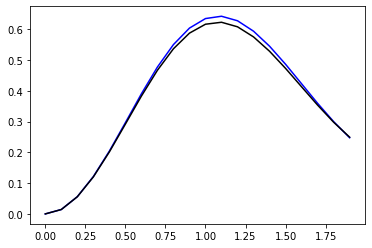

In [7]:
## Infinite number of measurements
# time step
dt = 0.1
# number of time steps
NSteps = 20
nSteps = [n for n in range(NSteps)]
# number of measurements per task
nShots = 0

P01_trotter = []

# Select local simulator as backend device
backend = Aer.get_backend('statevector_simulator')

# Run 20 time steps
for j in range(NSteps):
    circ = QuantumCircuit(2,2)
    
    circ = U_approx(circ, dt, nSteps[j], q)
    
    job = execute(circ, backend, shots = nShots)
    result = job.result()
    outputstatee = result.get_statevector(circ)
    
    P01_trotter.append(np.abs(outputstatee[2])**2) 

print('Probability 01 = ', P01_trotter)
Time = dt*np.arange(0,NSteps,1)
plt.plot(Time, P01_trotter, 'blue', Time, P01_exact, 'black')
    



Probability 01 =  [0, 0.022, 0.044, 0.12, 0.244, 0.336, 0.386, 0.46, 0.534, 0.5740000000000001, 0.588, 0.638, 0.632, 0.592, 0.518, 0.462, 0.444, 0.376, 0.296, 0.254]


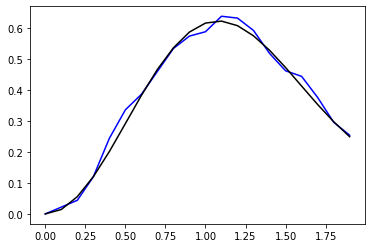

In [11]:
## Finite measurements statistics
#time step
dt = 0.1
# number of time steps
NSteps=20
nSteps=[n for n in range(NSteps)]
# number of measurements per task
nShots = 500

P01_trotter_finite = []

# Select Local simulator as a backend device
backend = Aer.get_backend('qasm_simulator')

# Run 20 time steps
for j in range(NSteps):
    circ = QuantumCircuit(2,2)
    circ = U_approx(circ, dt, nSteps[j], q)
    circ.z(q)
    circ.measure(range(2),range(2))
    
    job = execute(circ, backend, shots=nShots)
    
    result = job.result()
    count = result.get_counts(circ)
    
    try:
        var = count.get('10')
        P01_trotter_finite.append((1.0/nShots)*var)
    except:
        P01_trotter_finite.append(0)   
    
         
print('Probability 01 = ', P01_trotter_finite)


Time = dt*np.arange(0,NSteps,1)
plt.plot(Time, P01_trotter_finite, 'blue', Time, P01_exact, 'black')
    

